In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from math import sqrt
from skimage import exposure

In [2]:
img = Image.open('./Picture/cat-1.jpg')
img = img.resize((img.size[0],img.size[0]*2 ), Image.LANCZOS)
# img = img.resize((64,128), Image.LANCZOS)
img_pixel = np.array(img)

In [3]:
height, width, channel = img_pixel.shape
print("Height: {0}\nWidth: {1}\nChannel: {2}".format(height,width,channel))

Height: 2706
Width: 1353
Channel: 3


In [4]:
def gray_scale(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [5]:
gray = gray_scale(img_pixel, channel)

In [6]:
sobel_x = np.array([-1,0,1])
sobel_y = np.array([[-1],
                    [0],
                    [1]])

# [0] là theo trục y, [1] là theo trục x
cell_size = (8, 8)
block_size = (2, 2)
hist_size = 9

n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_size[0] + 1, n_cell[1] - block_size[1] + 1)

In [7]:
def calc_gradient(input, width, height):
  output_x = np.zeros((height,width))
  output_y = np.zeros((height,width))

  for r in range(height):
    for c in range(width):

      for i in range(-1,2):
        pixel_r = r + i
        pixel_r = min(max(0, pixel_r), height - 1)
        output_y[r,c] += input[pixel_r,c] * i

        pixel_c = c + i
        pixel_c = min(max(0, pixel_c), width - 1)
        output_x[r,c] += input[r,pixel_c] * i

  return output_x, output_y

In [8]:
gradient_x, gradient_y = calc_gradient(gray, width, height)

In [9]:
import numba as nb

In [10]:
print(nb.jit.__doc__)


    This decorator is used to compile a Python function into native code.

    Args
    -----
    signature_or_function:
        The (optional) signature or list of signatures to be compiled.
        If not passed, required signatures will be compiled when the
        decorated function is called, depending on the argument values.
        As a convenience, you can directly pass the function to be compiled
        instead.

    locals: dict
        Mapping of local variable names to Numba types. Used to override the
        types deduced by Numba's type inference engine.

    pipeline_class: type numba.compiler.CompilerBase
            The compiler pipeline type for customizing the compilation stages.

    options:
        For a cpu target, valid options are:
            nopython: bool
                Set to True to disable the use of PyObjects and Python API
                calls. The default behavior is to allow the use of PyObjects
                and Python API. Default value is Fa

In [11]:
from numba import cuda
import math
print(cuda.gpus)

<Managed Device 0>


In [12]:
cuda.is_available()

True

In [13]:
@cuda.jit
def gray_kernel(picture_in, gray_out):
    row, col = cuda.grid(2)
    print(row, col)
    image_rows, image_cols,channel = picture_in.shape
    if (row >= image_rows) or (col >= image_cols): 
        return
    rgb                = picture_in[row][col]
    gray_out[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    # assuming x and y inputs are same length

In [14]:
# Memory Allocation
out_host   = np.empty([img_pixel.shape[0], img_pixel.shape[1]],dtype = img_pixel.dtype)
x_device   = cuda.to_device(img_pixel)
height     = cuda.to_device(img_pixel.shape[0])
width      = cuda.to_device(img_pixel.shape[1])
out_device = cuda.device_array_like(out_host)

In [15]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(img_pixel.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(img_pixel.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
gray_kernel[blockspergrid, threadsperblock](x_device, out_device)

In [16]:
out_host = out_device.copy_to_host()

CudaAPIError: [702] Call to cuMemcpyDtoH results in CUDA_ERROR_LAUNCH_TIMEOUT

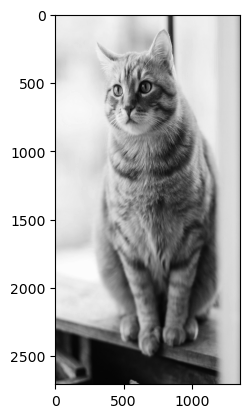

In [ ]:
plt.imshow(out_device,cmap='gray')